In [1]:
import argparse
import logging

import numpy as np
import torch.autograd
import torch.cuda
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import random

import copy
from datasets.maps_alt import MAPSDataset

#from cnn_ws.transformations.homography_augmentation import HomographyAugmentation
from cnn_ws.losses.cosine_loss import CosineLoss

from cnn_ws.models.myphocnet import PHOCNet
from cnn_ws.evaluation.retrieval import map_from_feature_matrix, map_from_query_test_feature_matrices
from torch.utils.data.dataloader import _DataLoaderIter as DataLoaderIter
from torch.utils.data.sampler import WeightedRandomSampler

from cnn_ws.utils.save_load import my_torch_save, my_torch_load

import matplotlib.pyplot as plt

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
if not torch.cuda.is_available():
    logger.warning('Could not find CUDA environment, using CPU mode')
    gpu_id = None
else:
    gpu_id = [0]
#torch.cuda.get_device_name(gpu_id[0])
pass

In [3]:
model_ = torch.load('PHOCNet_allcases_new.pt')
cnn = model_.module#list(model_.named_parameters())
if gpu_id is not None:
        if len(gpu_id) > 1:
            cnn = nn.DataParallel(cnn, device_ids=gpu_id)
            cnn.cuda()
        else:
            cnn.cuda(gpu_id[0])
cnn.training = False

In [4]:
# find the file names
f = open('../splits/val_files.txt', 'rb')
A = f.readlines()
f.close()
A = [x.rstrip('\n') for x in A]

In [5]:
# load test images and words
images_before = np.load('../../../detection_outputs_ready_for_test/detected_regions/'+A[0]+'.npy')
words_before = np.load('../../../detection_outputs_ready_for_test/detected_labels/'+A[0]+'.npy')

images_after = np.load('../../../detection_outputs_ready_for_test/new_regions/'+A[0]+'.npy')
words_after = np.load('../../../detection_outputs_ready_for_test/new_labels/'+A[0]+'.npy')

In [6]:
# filter the words and images on the basis of word lengths
# this is the same filtering that was happening in report matches
def clean_word_images(images, words, l):
    selected_idx = [x for x in range(len(words_before)) if len(words_before[x]) > l]
    images = images[selected_idx]
    words = words[selected_idx]
    return images, words

images_before, words_before = clean_word_images(images_before, words_before, 2)
images_after, words_after = clean_word_images(images_after, words_after, 2)

In [7]:
images_before = np.transpose(images_before, (0,3,1,2))
images_after = np.transpose(images_after, (0,3,1,2))
print 'images_before shape',images_before.shape
print 'words_before shape',words_before.shape
print 'images_after shape',images_after.shape
print 'words_after shape',words_after.shape

images_before shape (469, 3, 135, 487)
words_before shape (469,)
images_after shape (469, 3, 135, 487)
words_after shape (469,)


In [8]:
# assumption: words_before == words_after since the change is only happening in images
words = words_before

In [9]:
# convert image tnto embedding using the cnn model
def get_image_embeddings(images):
    outputs = []
    for i in tqdm(range(len(images))):
        word_img = images[i]
        word_img = 1 - word_img.astype(np.float32) / 255.0
        word_img = word_img.reshape((1,) + word_img.shape)
        word_img = torch.from_numpy(word_img).float()
        word_img = word_img.cuda(gpu_id[0])
        word_img = torch.autograd.Variable(word_img)
        output = torch.sigmoid(cnn(word_img))
        output = output.data.cpu().numpy().flatten()
        outputs.append(output)
    return outputs

outputs_before = get_image_embeddings(images_before)
outputs_after = get_image_embeddings(images_after)

100%|██████████| 469/469 [00:07<00:00, 62.06it/s]


In [10]:
# function to create word variations
# word_var is a dictionary that contains all variations as key and 0,1,-1 as value
# 0 denotes the root word, -1 denotes var = root_word[:-1], +1 denotes var = root_word[1:]
# root_word_var is a dict that stores original_word => all_variations
def create_word_variations(words):
    word_var = {}
    root_word_var = {}
    for w in words:
        if len(w) < 2:
            continue
        root_var_list = [w.lower(), w.upper(), w.capitalize()]
        var_set = set()
        for var in root_var_list:
            word_var[var] = 0
            word_var[var[1:]] = 1
            word_var[var[:-1]] = -1
            var_set.add(var)
            var_set.add(var[1:])
            var_set.add(var[:-1])
        root_word_var[w] = var_set
    return word_var, root_word_var

In [11]:
# compute the PHOC representation of the word itself
from cnn_ws.string_embeddings.phoc import build_phoc_descriptor
def get_word_phoc_representations(word_strings):
    unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
    bigram_levels = None
    bigrams = None
    phoc_unigram_levels=(1, 2, 4, 8)
    word_var_dir, root_word_var = create_word_variations(word_strings)
    
    word_var_strings = word_var_dir.keys()
    embedding_var = build_phoc_descriptor(words=word_var_strings,
                                  phoc_unigrams=unigrams,
                                  bigram_levels=bigram_levels,
                                  phoc_bigrams=bigrams,
                                  unigram_levels=phoc_unigram_levels)
    
    print('embedding variations:', embedding_var.shape)
    return (embedding_var, word_var_strings, word_var_dir, root_word_var)

emb_info = get_word_phoc_representations(words)
    

100%|██████████| 1871/1871 [00:00<00:00, 4701.36it/s]

('embedding variations:', (1871, 945))


In [12]:
# gets the embeddings for images before, images after and the ground truth word embeddings
def get_emb_images_words(outputs_before, outputs_after, words, emb_info):
    embedding_var, word_var_strings, word_var_dir, root_word_var = emb_info
    emb_list = []
    for i in range(len(words)):
        for j in range(len(word_var_strings)):
            if(word_var_strings[j] == words[i]):
                emb_list.append([outputs_before[i], outputs_after[i], embedding_var[j]])
                break
    return emb_list
emb_list = get_emb_images_words(outputs_before, outputs_after, words, emb_info)

In [13]:
phoc_len = 63 # number of characters supported by phoc

# function to display the heatmap
def show_heatmap(emb, title, labels):
    plt.figure(figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')
    plt.xticks(np.arange(0, emb.shape[1]+1, 1), np.array(labels))
    plt.yticks(np.arange(0, emb.shape[0]+1, 1))
    plt.title(title)
    plt.imshow(emb, cmap='binary', interpolation='nearest')
    plt.show()

# given an embedding array for an image, plots a heatmap of the embeddings
# for the actual text word, embeddings of original image and embedding
# of image after transformation (extension).
# all_embs: all the embeddings of a particular image obtained from get_emb_images_words
# word: The ground truth word
# level: The PHOC level that needs to be plotted [1,2,3,4]
# only_alphabets: boolean if True plots only alphabets on the heatmap (leaving out the digits and special characters)
def embedding_heatmap(all_embs, word, level, only_alphabets):
    if level == 1:
        l = 0
        r = phoc_len
    elif level == 2:
        l = phoc_len
        r = phoc_len*3
    elif level == 3:
        l = phoc_len*3
        r = phoc_len*7
    else:
        l = phoc_len*7
        r = phoc_len*15

    print 'Visualizing level',level,'embeddings for',word
    emb_word = all_embs[2][l:r].reshape((r-l)/phoc_len,phoc_len)
    emb_before = all_embs[0][l:r].reshape((r-l)/phoc_len,phoc_len)
    emb_after = all_embs[1][l:r].reshape((r-l)/phoc_len,phoc_len)

    if only_alphabets:
        unigrams = [chr(i) for i in range(ord('A'), ord('Z')+1) + range(ord('a'), ord('z') + 1)]
        lidx = 1
        ridx = 53
    else:
        unigrams = [chr(i) for i in range(ord('&'), ord('&')+1) + range(ord('A'), ord('Z')+1) + \
                    range(ord('a'), ord('z') + 1) + range(ord('0'), ord('9') + 1)]
        lidx = 0
        ridx = 63
    
    show_heatmap(emb_word[:,lidx:ridx], 'Heatmap for word text embedding', unigrams)
    show_heatmap(emb_before[:,lidx:ridx], 'Heatmap for before image embedding', unigrams)
    show_heatmap(emb_after[:,lidx:ridx], 'Heatmap for after image embedding', unigrams)

## Plot Description
* Three plots will be made
    * Heatmap for word text embedding
    * Heatmap for before image embedding
    * Heatmap for after image embedding
* Each plot may be nxd depending on the level being visualized e.g At level 1, n=1. At level 2, n=2, At level 3, n=4 and at level 4, n=8
* Black squares on the heatmap represent 1, while white squares represent 0, and greys the values in between
* embedding_heatmap plots the embedding. Just use the index of images to get embeddings and ground truth word to pass into embedding_heatmap. Image indexes can be found from the last celll in the notebook. e.g The below cell plots embeddings for RANDOLPH (index 22) at level 1.

## Analysis
* Still working on analyzing the embeddings
* Some things that I could observe is that the embeddings in general become more noisy (deviate more from ground truth embedding) after the extension was done

Visualizing level 1 embeddings for RANDOLPH


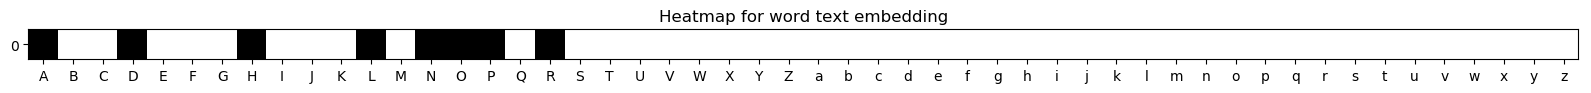

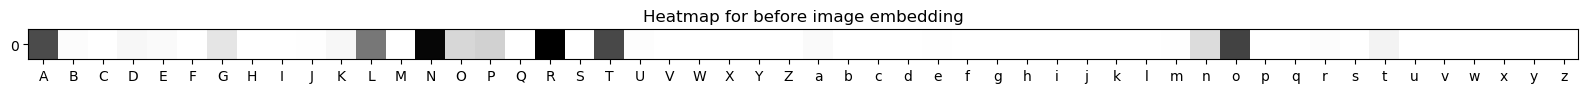

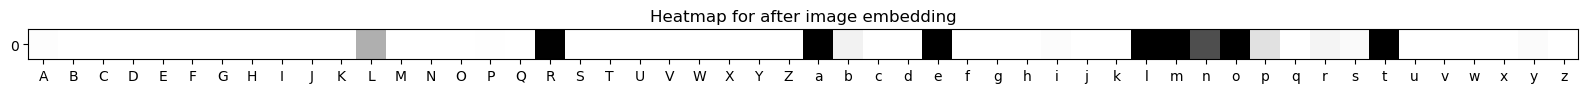

In [14]:

embedding_heatmap(emb_list[22], words[22], 1, True)

In [15]:
# gets the actual distances of all the ground truth word variations
def get_all_dist_gt(dist_mat, emb_info, words):
    # expand emb_info tuple
    embedding_var, word_var_strings, word_var_dir, root_word_var = emb_info
    all_dist = []
    for i in range(len(words)):
        w_dist = []
        w_vars = root_word_var[words[i]]
        for j in range(len(word_var_strings)):
            if word_var_strings[j] in w_vars:
                w_dist.append((word_var_strings[j], dist_mat[i][j]))
        all_dist.append(w_dist)
    return all_dist

# the new report matches method that handles variations
from scipy.spatial.distance import cdist, pdist, squareform
def report_matches_with_variations(outputs, matching, word_strings, emb_info, k):
    # expand emb_info tuple
    embedding_var, word_var_strings, word_var_dir, root_word_var = emb_info
    
    # the real computation
    dist_mat = cdist(XA=outputs, XB=embedding_var, metric=matching)
    gt_words_dist = get_all_dist_gt(dist_mat, emb_info, word_strings)
    retrieval_indices = np.argsort(dist_mat, axis=1)
    q = retrieval_indices[:,:k]
    count = 0
    matched_words = []
    img_dir = []
    words_len = []
    actual_dist = []
    # get all matched words
    for i in range(len(q)):
        matched = []
        for j in q[i]:
            actual_dist.append(dist_mat[i][j])
            matched.append(word_var_strings[j])
            curr_len = len(word_var_strings[j])
            curr_dir = word_var_dir[word_var_strings[j]]
            words_len.append(curr_len + abs(curr_dir))
            img_dir.append(curr_dir)
        matched_words.append(matched)
    
    # calculate accuracies
    is_correct = []
    for i in range(len(word_strings)):
        #print word_strings[i]
        is_correct.append(0)
        if word_strings[i] in matched_words[i]:
            is_correct[i] = 1
            count = count+1
        else:
            for w in matched_words[i]:
                if w in root_word_var[word_strings[i]]:
                    is_correct[i] = 2
                    count = count+1
                    break

    #q = np.squeeze(np.array(q))
    #p = np.arange(len(q))
    #print count
    return (count, matched_words, img_dir, words_len, actual_dist, is_correct, gt_words_dist)

In [16]:
# get the matches report
match_report_before = report_matches_with_variations(outputs_before,'cosine',words,emb_info,1)
match_report_after = report_matches_with_variations(outputs_after,'cosine',words,emb_info,1)

Almost classified before and In-correctly classified after
************************************************************************
************************************************************************


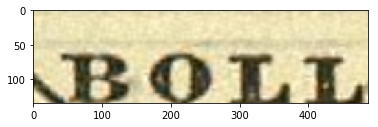

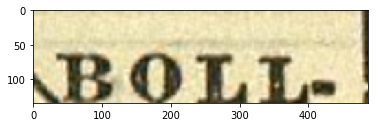

Image Index: 12
Matched before: $Boll$
Matched after:$Bloomfield$
Ground truth:BOLL-
Image Dir before:-1
Image Dir after:0
Distance before:0.30853331434750775
Distance after:0.37088286620686584

All Distances Before:[('boll', 0.46825348004611445), ('Boll', 0.30853331434750775), ('OLL-', 0.9983079812083073), ('Boll-', 0.4775694020802509), ('oll-', 0.6732458142769094), ('boll-', 0.6469270466316821), ('BOLL', 0.8356562686015607), ('BOLL-', 0.8290013891780579)]

All Distances After:[('boll', 0.6017190212560988), ('Boll', 0.4110231632845359), ('OLL-', 0.9999674850033512), ('Boll-', 0.43116937245655673), ('oll-', 0.5628639346965195), ('boll-', 0.633430657685759), ('BOLL', 0.8091343625519176), ('BOLL-', 0.7975592449159956)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
******************************************************

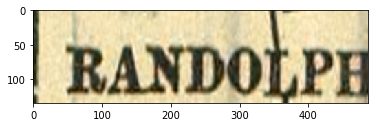

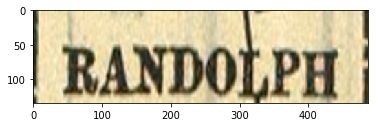

Image Index: 22
Matched before: $RANDOLP$
Matched after:$monitea$
Ground truth:RANDOLPH
Image Dir before:-1
Image Dir after:-1
Distance before:0.44203422421252636
Distance after:0.4714890981023723

All Distances Before:[('RANDOLPH', 0.4787656842245549), ('RANDOLP', 0.44203422421252636), ('ANDOLPH', 0.7626489652437708), ('Randolph', 0.5748793855033578), ('randolp', 0.7021729298964885), ('Randolp', 0.5473745514326765), ('randolph', 0.7196800095632954), ('andolph', 0.8751606091240061)]

All Distances After:[('RANDOLPH', 0.865021010175137), ('RANDOLP', 0.8557534768087777), ('ANDOLPH', 0.9872479752675194), ('Randolph', 0.5301321939297878), ('randolp', 0.6392739501926141), ('Randolp', 0.5096839244099451), ('randolph', 0.651352563235275), ('andolph', 0.6229261487835924)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
******

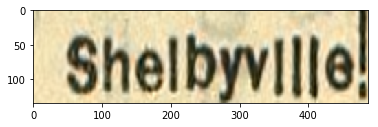

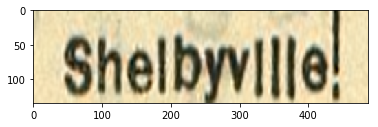

Image Index: 57
Matched before: $shelbyvill$
Matched after:$showin$
Ground truth:Shelbyville
Image Dir before:-1
Image Dir after:-1
Distance before:0.2615935577422732
Distance after:0.4520390108832657

All Distances Before:[('helbyville', 0.3967239013129543), ('shelbyvill', 0.2615935577422732), ('shelbyville', 0.2886401711851849), ('Shelbyvill', 0.36060924716026566), ('SHELBYVILLE', 0.9998791730587383), ('SHELBYVILL', 0.9998454303208896), ('HELBYVILLE', 0.9999839372786266), ('Shelbyville', 0.3902281250448323)]

All Distances After:[('helbyville', 0.5840660441990979), ('shelbyvill', 0.4974824380251911), ('shelbyville', 0.48121131986468524), ('Shelbyvill', 0.5602533187300784), ('SHELBYVILLE', 0.9699398509119815), ('SHELBYVILL', 0.9706986778777342), ('HELBYVILLE', 0.9999995668862759), ('Shelbyville', 0.5456128846092194)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************

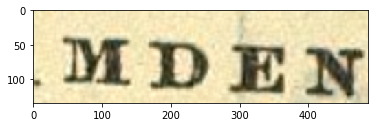

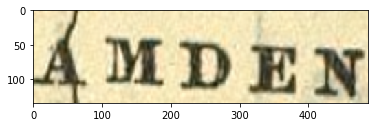

Image Index: 61
Matched before: $AMDEN$
Matched after:$ALLATIN$
Ground truth:CAMDEN
Image Dir before:1
Image Dir after:1
Distance before:0.33889244929317797
Distance after:0.3120580596749094

All Distances Before:[('camde', 0.9999844357317195), ('CAMDEN', 0.5235060545795509), ('amden', 0.9999879891368265), ('AMDEN', 0.33889244929317797), ('Camde', 0.9999837570817358), ('Camden', 0.9999847043601126), ('CAMDE', 0.7403609376511098), ('camden', 0.9999853426575296)]

All Distances After:[('camde', 0.9999999999904963), ('CAMDEN', 0.48043076053656086), ('amden', 0.9999999999709709), ('AMDEN', 0.4047036458296923), ('Camde', 0.9999999936888716), ('Camden', 0.9999999940612174), ('CAMDE', 0.7262838566970924), ('camden', 0.999999999988147)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
******************************************

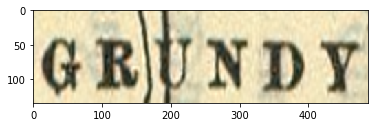

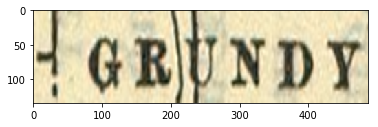

Image Index: 78
Matched before: $RUNDY$
Matched after:$GREENE$
Ground truth:GRUNDY
Image Dir before:1
Image Dir after:0
Distance before:0.3994564324730121
Distance after:0.45924172301706656

All Distances Before:[('Grund', 0.9992007421676289), ('grund', 0.9999771256333535), ('rundy', 0.9999685011016285), ('grundy', 0.9999644068540828), ('GRUND', 0.6846624476942111), ('Grundy', 0.9992341871933863), ('GRUNDY', 0.5260924480088611), ('RUNDY', 0.3994564324730121)]

All Distances After:[('Grund', 0.8670267415341915), ('grund', 0.9317903243518484), ('rundy', 0.9526706551452231), ('grundy', 0.9548035268143301), ('GRUND', 0.5658402282840466), ('Grundy', 0.8938907903143778), ('GRUNDY', 0.5174762414979928), ('RUNDY', 0.5477889183524536)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
********************************************

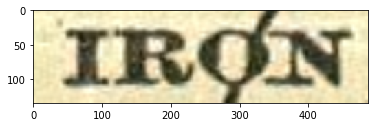

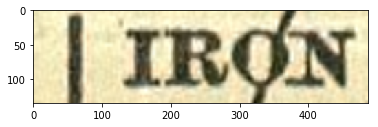

Image Index: 84
Matched before: $RON$
Matched after:$rundy$
Ground truth:IRON
Image Dir before:1
Image Dir after:1
Distance before:0.2592918876827316
Distance after:0.5341148647098575

All Distances Before:[('Iro', 0.9998677465525021), ('iron', 0.9999998588778506), ('IRON', 0.5432830664077732), ('ron', 0.999999988146778), ('iro', 0.9999999989163982), ('Iron', 0.9999044642948635), ('IRO', 0.8199097254970132), ('RON', 0.2592918876827316)]

All Distances After:[('Iro', 0.996453992654701), ('iron', 0.9608629300211647), ('IRON', 0.9624675366980419), ('ron', 0.9948387453441268), ('iro', 0.9473315613268947), ('Iron', 0.99377351186204), ('IRO', 0.9956485695174252), ('RON', 0.9959814169614886)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


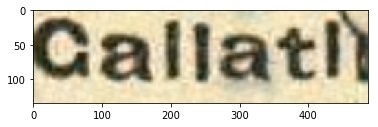

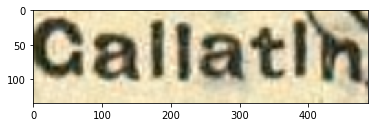

Image Index: 116
Matched before: $gallati$
Matched after:$olath$
Ground truth:Gallatin
Image Dir before:-1
Image Dir after:-1
Distance before:0.1985221844116497
Distance after:0.34377993144654706

All Distances Before:[('gallatin', 0.388007115648481), ('allatin', 0.5408860595437086), ('GALLATI', 0.9999501206573249), ('gallati', 0.1985221844116497), ('Gallatin', 0.38801915679730814), ('Gallati', 0.19853519033885958), ('ALLATIN', 0.9999751016291016), ('GALLATIN', 0.9999543143018863)]

All Distances After:[('gallatin', 0.365138781069148), ('allatin', 0.4198625356047436), ('GALLATI', 0.9999831586309057), ('gallati', 0.3955080706954217), ('Gallatin', 0.365210347612142), ('Gallati', 0.395585371396726), ('ALLATIN', 0.9999894356595121), ('GALLATIN', 0.9999835096128533)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
********

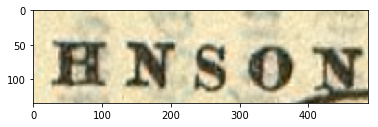

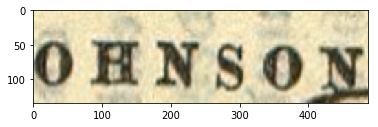

Image Index: 135
Matched before: $OHNSON$
Matched after:$ackson$
Ground truth:JOHNSON
Image Dir before:1
Image Dir after:1
Distance before:0.394667339846715
Distance after:0.34553733223110694

All Distances Before:[('johnso', 0.9956242398321542), ('johnson', 0.9888611018157785), ('Johnson', 0.9888471941679481), ('Johnso', 0.9956100567586191), ('JOHNSO', 0.7653479139629022), ('ohnson', 0.9751294567825858), ('JOHNSON', 0.5659773991792668), ('OHNSON', 0.394667339846715)]

All Distances After:[('johnso', 0.6321156641005556), ('johnson', 0.48011183229258036), ('Johnson', 0.4794198334138323), ('Johnso', 0.6314099609433315), ('JOHNSO', 0.8585195046231359), ('ohnson', 0.3705718537790429), ('JOHNSON', 0.8496946551725744), ('OHNSON', 0.7956710894861557)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
**************************

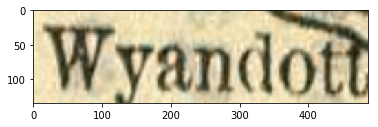

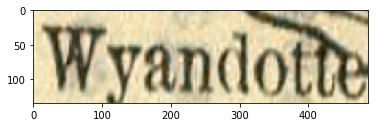

Image Index: 155
Matched before: $Wyandott$
Matched after:$Waynes$
Ground truth:Wyandotte
Image Dir before:-1
Image Dir after:0
Distance before:0.43255647182699275
Distance after:0.39250045206402395

All Distances Before:[('WYANDOTTE', 0.867652671042001), ('Wyandotte', 0.4976824069325966), ('wyandott', 0.45194172709796343), ('yandotte', 0.7121153554219635), ('YANDOTTE', 0.9992899774817898), ('Wyandott', 0.43255647182699275), ('wyandotte', 0.5148444766242162), ('WYANDOTT', 0.8505082761721903)]

All Distances After:[('WYANDOTTE', 0.8618154998016997), ('Wyandotte', 0.48602297751688617), ('wyandott', 0.4768851169308891), ('yandotte', 0.567941822041844), ('YANDOTTE', 0.9953866805688983), ('Wyandott', 0.4639576666070867), ('wyandotte', 0.4974678514837656), ('WYANDOTT', 0.843914484666777)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************

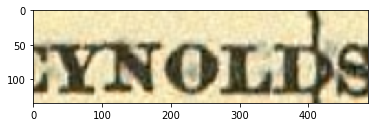

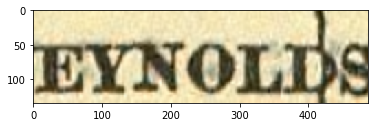

Image Index: 157
Matched before: $EYNOLDS$
Matched after:$ENTONVILLE$
Ground truth:REYNOLDS
Image Dir before:1
Image Dir after:1
Distance before:0.4419524830704957
Distance after:0.3729671582639471

All Distances Before:[('eynolds', 0.8232835673471532), ('REYNOLDS', 0.6074638608347593), ('reynold', 0.8552408407389558), ('REYNOLD', 0.6869068460154559), ('Reynolds', 0.9070256189838483), ('reynolds', 0.9070175488298107), ('Reynold', 0.8552494680965178), ('EYNOLDS', 0.4419524830704957)]

All Distances After:[('eynolds', 0.9998284155781587), ('REYNOLDS', 0.4867510943664245), ('reynold', 0.9961662066100041), ('REYNOLD', 0.5173640493966696), ('Reynolds', 0.9998390803624532), ('reynolds', 0.9998391887552789), ('Reynold', 0.9961660907331993), ('EYNOLDS', 0.39042230300778047)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
***

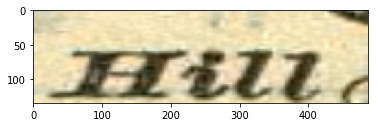

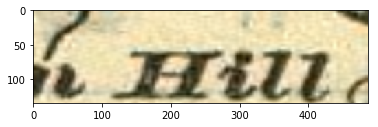

Image Index: 160
Matched before: $ill$
Matched after:$bate$
Ground truth:Hill
Image Dir before:1
Image Dir after:-1
Distance before:0.5127519012983957
Distance after:0.47692489779900316

All Distances Before:[('ill', 0.5127519012983957), ('ILL', 0.9893734337654545), ('Hil', 0.5245905248697604), ('hill', 0.5911544645551179), ('Hill', 0.5911584093113403), ('hil', 0.5245871790650263), ('HIL', 0.9899809938486682), ('HILL', 0.9898836813260901)]

All Distances After:[('ill', 0.9802216480630342), ('ILL', 0.9999990428638351), ('Hil', 0.9812672762491086), ('hill', 0.9834239208284752), ('Hill', 0.9834352070680404), ('hil', 0.9812638645639954), ('HIL', 0.9999992338936383), ('HILL', 0.9999941968552236)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


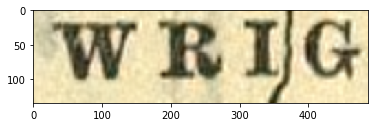

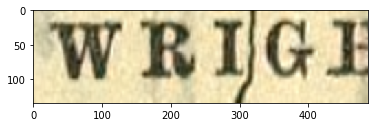

Image Index: 232
Matched before: $WRIGH$
Matched after:$CENTREVILLE$
Ground truth:WRIGHT
Image Dir before:-1
Image Dir after:0
Distance before:0.499706734306801
Distance after:0.4030491223429883

All Distances Before:[('wright', 0.973710710788968), ('right', 0.9999765712417481), ('wrigh', 0.971981144953618), ('WRIGHT', 0.5985789813098286), ('Wright', 0.8314357565403034), ('Wrigh', 0.8207117009619016), ('WRIGH', 0.499706734306801), ('RIGHT', 0.7519886680613003)]

All Distances After:[('wright', 0.9999999532874693), ('right', 0.9999999999794186), ('wrigh', 0.9999999497566292), ('WRIGHT', 0.5920207711295988), ('Wright', 0.8248514733405683), ('Wrigh', 0.8137787464712259), ('WRIGH', 0.45275656934429453), ('RIGHT', 0.7524852842127149)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
*****************************************

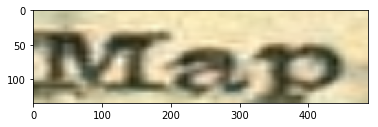

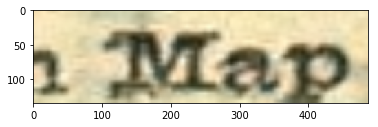

Image Index: 237
Matched before: $ap$
Matched after:$randolp$
Ground truth:Map
Image Dir before:1
Image Dir after:-1
Distance before:0.5407238506321563
Distance after:0.5139575031506525

All Distances Before:[('MAP', 0.9999110997842853), ('ma', 0.8343747466883895), ('AP', 0.9999371560646053), ('Ma', 0.8580401177755491), ('MA', 0.9999551447015418), ('map', 0.5838202887614283), ('ap', 0.5407238506321563), ('Map', 0.6060517918649335)]

All Distances After:[('MAP', 0.9976012993102795), ('ma', 0.8017172352914792), ('AP', 0.9974965446314442), ('Ma', 0.8890965675483977), ('MA', 0.9999456176393541), ('map', 0.5662588211167159), ('ap', 0.5371659699001933), ('Map', 0.6484626866097272)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


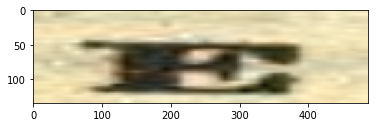

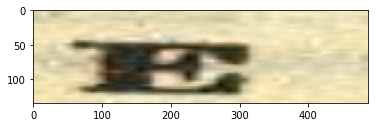

Image Index: 244
Matched before: $PIK$
Matched after:$EB.$
Ground truth:PIKE
Image Dir before:-1
Image Dir after:1
Distance before:0.5891319730092544
Distance after:0.12793599760408292

All Distances Before:[('Pike', 0.7180215741135431), ('PIKE', 0.6952348637657311), ('Pik', 0.6048460256622233), ('ike', 0.9841271785783012), ('PIK', 0.5891319730092544), ('pike', 0.972059768005365), ('IKE', 0.9943171695447073), ('pik', 0.9729190454681302)]

All Distances After:[('Pike', 0.9903485095402847), ('PIKE', 0.9017473520581207), ('Pik', 0.9928383064390517), ('ike', 0.9959750018149178), ('PIK', 0.9965669377025738), ('pike', 0.9908843665900736), ('IKE', 0.8566669183744084), ('pik', 0.993062090978314)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


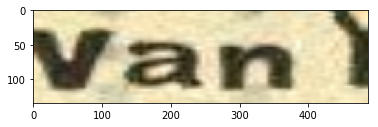

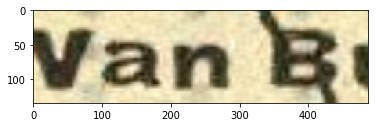

Image Index: 272
Matched before: $an$
Matched after:$rancisco$
Ground truth:Van
Image Dir before:-1
Image Dir after:1
Distance before:0.32442926286629337
Distance after:0.38295386798633724

All Distances Before:[('VA', 0.9999146450654958), ('Va', 0.7537474213203804), ('AN', 0.999997963778883), ('an', 0.32442926286629337), ('Van', 0.5475421061256709), ('VAN', 0.9999177147362817), ('va', 0.7535854396919375), ('van', 0.5473909509757684)]

All Distances After:[('VA', 0.9706238989865023), ('Va', 0.8783282540779127), ('AN', 0.9999997266411254), ('an', 0.6357602200868806), ('Van', 0.715560587477755), ('VAN', 0.9724585795161929), ('va', 0.9058769624660528), ('van', 0.7414040449110306)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


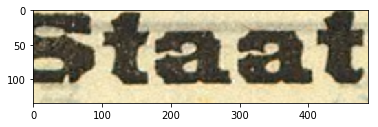

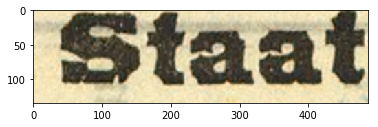

Image Index: 277
Matched before: $taat$
Matched after:$ERA$
Ground truth:Staat
Image Dir before:1
Image Dir after:1
Distance before:0.3652840715592026
Distance after:0.4764009034006239

All Distances Before:[('Staa', 0.7017185071869981), ('TAAT', 0.9830135308304503), ('Staat', 0.3840669882012261), ('STAAT', 0.9841585061886368), ('STAA', 0.9972965788169027), ('staat', 0.3834825274301563), ('taat', 0.3652840715592026), ('staa', 0.7011176374986975)]

All Distances After:[('Staa', 0.9987329837311796), ('TAAT', 0.7239344755834092), ('Staat', 0.9983946193815537), ('STAAT', 0.7303611163628794), ('STAA', 0.8199411170412072), ('staat', 0.9994022700021704), ('taat', 0.999386615302668), ('staa', 0.9998165608634528)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
******************************************************************

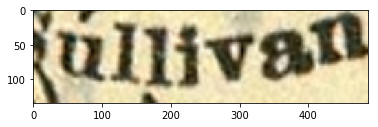

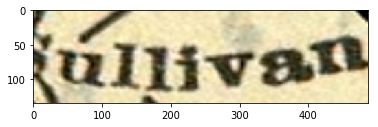

Image Index: 287
Matched before: $ullivan$
Matched after:$aline$
Ground truth:Sullivan
Image Dir before:1
Image Dir after:1
Distance before:0.42715775774491127
Distance after:0.3768074770359656

All Distances Before:[('SULLIVA', 0.9840405384142883), ('sullivan', 0.4945053661888177), ('ullivan', 0.42715775774491127), ('Sulliva', 0.6303799685206574), ('ULLIVAN', 0.9715186679645985), ('sulliva', 0.6303772500562757), ('SULLIVAN', 0.9777449186460836), ('Sullivan', 0.49450789021963115)]

All Distances After:[('SULLIVA', 0.9994312247921009), ('sullivan', 0.5193877977736292), ('ullivan', 0.4931963359578717), ('Sulliva', 0.677694112593307), ('ULLIVAN', 0.9993032543919229), ('sulliva', 0.6776941020714198), ('SULLIVAN', 0.9994029208793362), ('Sullivan', 0.5193878075429561)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
*******

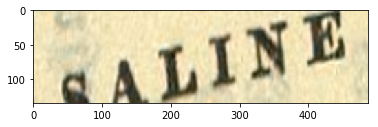

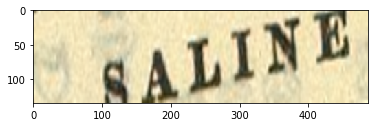

Image Index: 297
Matched before: $ALINE$
Matched after:$TANE$
Ground truth:SALINE
Image Dir before:1
Image Dir after:-1
Distance before:0.15027852901773342
Distance after:0.22575851618030596

All Distances Before:[('ALINE', 0.15027852901773342), ('salin', 0.9999999999863313), ('aline', 0.9999998845192383), ('Salin', 0.9997911279651391), ('saline', 0.9999999999749111), ('SALIN', 0.5485090031642602), ('SALINE', 0.2608205481999264), ('Saline', 0.9998035474959784)]

All Distances After:[('ALINE', 0.4196307522121926), ('salin', 0.986641766706476), ('aline', 0.9141158426009384), ('Salin', 0.9744592923921498), ('saline', 0.9191974288926605), ('SALIN', 0.6112804756736607), ('SALINE', 0.41669990988373107), ('Saline', 0.9077393251939307)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
******************************************

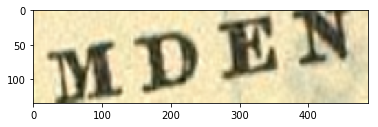

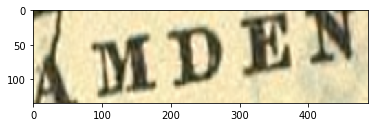

Image Index: 298
Matched before: $AMDEN$
Matched after:$MILLER$
Ground truth:CAMDEN
Image Dir before:1
Image Dir after:0
Distance before:0.3655658363749995
Distance after:0.3099746392600098

All Distances Before:[('camde', 0.9839687106044892), ('CAMDEN', 0.5294930185489957), ('amden', 0.9416982426238142), ('AMDEN', 0.3655658363749995), ('Camde', 0.9841063379091064), ('Camden', 0.9485894892689322), ('CAMDE', 0.6879524732154086), ('camden', 0.9484600452916749)]

All Distances After:[('camde', 0.9999687764329511), ('CAMDEN', 0.5067662067670435), ('amden', 0.9997692705753113), ('AMDEN', 0.4369132077982285), ('Camde', 0.9999687731274645), ('Camden', 0.9998405590835955), ('CAMDE', 0.7283122344527455), ('camden', 0.9998405621925377)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
********************************************

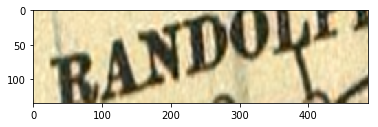

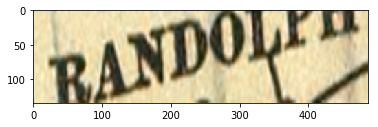

Image Index: 334
Matched before: $RANDOLP$
Matched after:$ANDRE$
Ground truth:RANDOLPH
Image Dir before:-1
Image Dir after:-1
Distance before:0.32105534581819184
Distance after:0.3403391934407882

All Distances Before:[('RANDOLPH', 0.3965803807572784), ('RANDOLP', 0.32105534581819184), ('ANDOLPH', 0.6565286776894743), ('Randolph', 0.8681110125007072), ('randolp', 0.999995448508372), ('Randolp', 0.8590054647775155), ('randolph', 0.9999950660226313), ('andolph', 0.9999992086642729)]

All Distances After:[('RANDOLPH', 0.46704306225621117), ('RANDOLP', 0.4329635442851132), ('ANDOLPH', 0.6508523239543507), ('Randolph', 0.9516907600021985), ('randolp', 0.9999668637135409), ('Randolp', 0.9483643709839407), ('randolph', 0.9999604720266129), ('andolph', 0.9999706248821622)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
*****

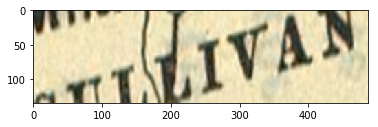

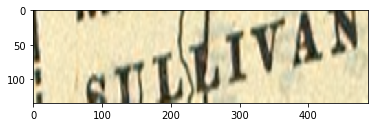

Image Index: 337
Matched before: $ILAN$
Matched after:$TEN$
Ground truth:Milan
Image Dir before:1
Image Dir after:-1
Distance before:0.4143638877538023
Distance after:0.45079645219032605

All Distances Before:[('Milan', 0.9949777066604907), ('MILA', 0.7263034153777963), ('MILAN', 0.486584082705369), ('mila', 1.0), ('Mila', 0.9946115176140465), ('milan', 1.0), ('ilan', 1.0), ('ILAN', 0.4143638877538023)]

All Distances After:[('Milan', 0.9084254508116092), ('MILA', 0.8210638780576405), ('MILAN', 0.7031739654385623), ('mila', 0.841391289980721), ('Mila', 0.845434398610994), ('milan', 0.9048183055769614), ('ilan', 0.893276361002428), ('ILAN', 0.6680332718985391)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
************************************************************************


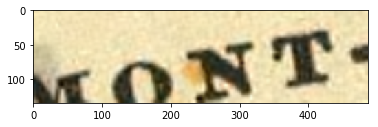

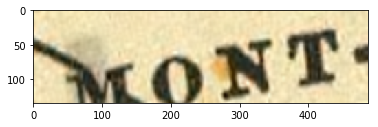

Image Index: 355
Matched before: $ont-$
Matched after:$monr$
Ground truth:MONT-
Image Dir before:1
Image Dir after:-1
Distance before:0.35517999751581664
Distance after:0.3357673489724201

All Distances Before:[('MONT-', 0.9846114159839592), ('ont-', 0.35517999751581664), ('Mont-', 0.5540171637162576), ('mont', 0.7432667788819698), ('Mont', 0.7439839630426759), ('ONT-', 0.979243928720815), ('mont-', 0.5532857619352287), ('MONT', 0.9872541794590597)]

All Distances After:[('MONT-', 0.9912197803790618), ('ont-', 0.7140842203686326), ('Mont-', 0.5127997149569463), ('mont', 0.3489722318266806), ('Mont', 0.38607453636607447), ('ONT-', 0.9915791133153707), ('mont-', 0.47496336256806093), ('MONT', 0.98988418689747)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
**************************************************************

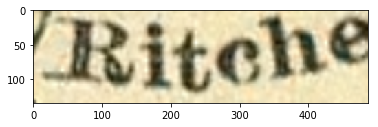

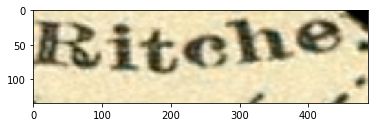

Image Index: 401
Matched before: $Ritche$
Matched after:$litchfiel$
Ground truth:Ritchey
Image Dir before:-1
Image Dir after:-1
Distance before:0.474068261515984
Distance after:0.4050515320876167

All Distances Before:[('RITCHEY', 0.8419715537063868), ('ritchey', 0.7225121144518316), ('ritche', 0.6359161461360257), ('Ritche', 0.474068261515984), ('Ritchey', 0.5665515904108859), ('itchey', 0.7937769880182051), ('RITCHE', 0.8359697573644467), ('ITCHEY', 0.9998332450231144)]

All Distances After:[('RITCHEY', 0.998605595661917), ('ritchey', 0.455319375300681), ('ritche', 0.4569377255081901), ('Ritche', 0.45563645625276816), ('Ritchey', 0.45406544087039524), ('itchey', 0.49465914505654685), ('RITCHE', 0.9985527483039927), ('ITCHEY', 0.9999995356621687)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
**********************

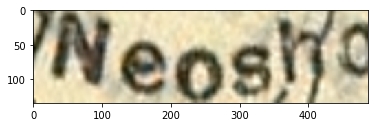

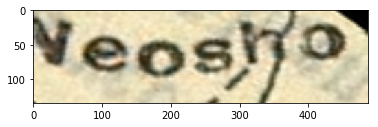

Image Index: 409
Matched before: $Neosh$
Matched after:$enn$
Ground truth:Neosho
Image Dir before:-1
Image Dir after:1
Distance before:0.3191866038511467
Distance after:0.3963310148562096

All Distances Before:[('eosho', 0.5935295756845598), ('Neosho', 0.4431292495419986), ('NEOSHO', 0.8771030449430924), ('EOSHO', 0.9997757496163637), ('Neosh', 0.3191866038511467), ('neosh', 0.44592640968412034), ('NEOSH', 0.8719948954094943), ('neosho', 0.5646938007564603)]

All Distances After:[('eosho', 0.7308396870951556), ('Neosho', 0.6966373919880564), ('NEOSHO', 0.9999910544708834), ('EOSHO', 0.9999932718792548), ('Neosh', 0.797885995190009), ('neosh', 0.6996775345762742), ('NEOSH', 0.9999920956315053), ('neosho', 0.6024391457345835)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
**********************************************

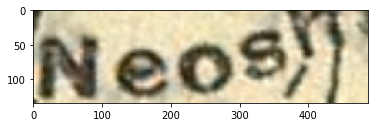

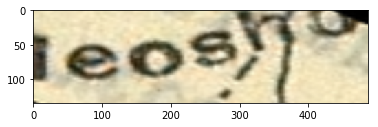

Image Index: 463
Matched before: $Neosh$
Matched after:$centreville$
Ground truth:Neosho
Image Dir before:-1
Image Dir after:0
Distance before:0.39853046376618306
Distance after:0.44854693290070524

All Distances Before:[('eosho', 0.6598052627258604), ('Neosho', 0.42202319584559556), ('NEOSHO', 0.7876283958860537), ('EOSHO', 0.9903001300841411), ('Neosh', 0.39853046376618306), ('neosh', 0.5975994276753381), ('NEOSH', 0.7783402079268029), ('neosho', 0.612963438331341)]

All Distances After:[('eosho', 0.6760848543012549), ('Neosho', 0.7013918652426132), ('NEOSHO', 0.9999991421842007), ('EOSHO', 0.9999999166772555), ('Neosh', 0.7823805424791344), ('neosh', 0.7823805674031595), ('NEOSH', 0.9999997955549954), ('neosho', 0.7013918891488984)]
------------------------------------------------------------------------
------------------------------------------------------------------------
************************************************************************
***********************************

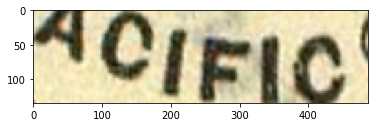

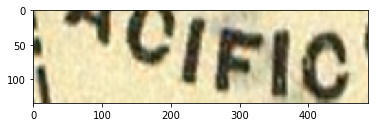

Image Index: 466
Matched before: $ACIFIC$
Matched after:$PRINGFIELD$
Ground truth:PACIFIC
Image Dir before:1
Image Dir after:1
Distance before:0.42981478969167985
Distance after:0.42053111395069365

All Distances Before:[('PACIFIC', 0.5112827334758281), ('Pacific', 0.9891934067600747), ('Pacifi', 0.9887520523622548), ('pacific', 0.9999999979661136), ('ACIFIC', 0.42981478969167985), ('PACIFI', 0.68526438788901), ('acific', 0.9999999744924282), ('pacifi', 0.9999999091041254)]

All Distances After:[('PACIFIC', 0.8195911468926234), ('Pacific', 0.9999963015403662), ('Pacifi', 0.999995627311924), ('pacific', 0.9999997166697568), ('ACIFIC', 0.7379313696709004), ('PACIFI', 0.8302925502045493), ('acific', 0.9999999963656306), ('pacifi', 0.9999991818912921)]
------------------------------------------------------------------------
------------------------------------------------------------------------
26


In [17]:
print "Almost classified before and In-correctly classified after"
import matplotlib.pyplot as plt
count = 0
for i in range(len(words)):
    if match_report_before[5][i] == 2 \
    and match_report_after[5][i] == 0:
        count += 1
        print "************************************************************************"
        print "************************************************************************"
        q = np.transpose(images_before[i],(1,2,0))
        q1 = np.transpose(images_after[i],(1,2,0))
        plt.imshow(q)
        plt.show()
        plt.imshow(q1)
        plt.show()
        print "Image Index: " + str(i)
        print "Matched before: "+"$"+str(match_report_before[1][i][0])+"$"
        print "Matched after:" + "$"+str(match_report_after[1][i][0])+"$"
        print "Ground truth:" + str(words[i])
        print "Image Dir before:" + str(match_report_before[2][i])
        print "Image Dir after:" + str(match_report_after[2][i])
        print "Distance before:" + str(match_report_before[4][i])
        print "Distance after:" + str(match_report_after[4][i])
        print "\nAll Distances Before:" + str(match_report_before[6][i])
        print "\nAll Distances After:" + str(match_report_after[6][i])
        print "------------------------------------------------------------------------"
        print "------------------------------------------------------------------------"
        
print count

## Details
* The above plot shows images that were almost correctly classified before (matched with word variation of the root word) and were mis-classified after we tried to extend them
* The first image corresponds to before extension and second image corresponds to after extension
* Every image's index is printed on the first line after the image. The index is used for heatmap plotting shown above
* The plot aslo mentions other details like, best distance and match before, best distance and match after and distances of the ground truth and its variations before and after

## Current Analysis
* From the above plot it can be seen that distances for ground truth and its variations is changing significantly after the images are extended.
    * For e.g in case of RANDOLPH (index 22), one would expect distance of "RANDOLPH" to come down. But on the contrary, the distance increased
    * But in CAMDEN (index 61) case, although distance of "CAMDEN" came down, distance of "AMDEN" (previous prediction) goes above
* Haven't been able to reach any conclusive results yet